# **FeatureEngineering**

## Objectives

* Further data preparation for the ML algorithm by performing several steps of feature engineering

## Inputs

* Dataset in outputs/datasets/cleaned/TrainSetCleaned.csv

## Outputs

* No file output but we get a decision on the ML pipeline transformations/encoders

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspace/attrition-predictor'

---

# Load Training dataset

The data does not have missing values, therefore we will not need any imputer. In the last notebook, we already dropped 7 columns from the dataset of 35 columns, leaving 28 columns including the target. The target `Attrition` was transformed from a categorical variable (Yes, No) to a numerical one (1, 0). The operation was done manually and mimics an ordinal encoder.

As mentioned before, there are 8 categorical variables (after dropping `Over18`) including `Attrition`. These will be subjected to OrdinalCategoricalEncoder.

As for the numerical data, we will have to look on their distribution (QQ plots and histogram)..


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
TrainSet = pd.read_csv(f"outputs/datasets/cleaned/TrainSetCleaned.csv")
TrainSet.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,58,0,Travel_Rarely,Sales,21,3,Life Sciences,4,Female,3,...,3,3,1,29,2,2,1,0,0,0
1,45,0,Travel_Rarely,Research & Development,28,3,Technical Degree,4,Male,3,...,4,4,1,8,3,3,5,4,0,3
2,40,0,Travel_Rarely,Sales,26,3,Marketing,3,Male,3,...,3,2,1,8,3,2,7,7,7,5
3,36,0,Non-Travel,Sales,8,4,Life Sciences,1,Male,2,...,3,2,0,10,1,3,10,7,0,9
4,25,1,Travel_Frequently,Sales,24,1,Life Sciences,3,Male,1,...,3,4,0,1,4,3,1,0,1,0


Next, we will perform:
* Visualize data distribution to decide which numerical data to apply transformation to
* Numerical data transformation
* Categorical encoding

---

# Numerical data distribution

We plot all numerical columns and calculate their skewness and kurtosis to see how far they are from normal distribution.

In [ ]:
import pingouin as pg

def plot_distribution(dataframe):

    for col in dataframe.columns:
        if dataframe[col].dtype=='int64':
            print(f"*** {col} ***")
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), width_ratios = [1, 1])
            sns.histplot(data=dataframe, x=col, ax=axes[0], kde=True, multiple="stack")
            qqplot = pg.qqplot(dataframe[col], dist='norm', ax=axes[1])
            qqplot.set(xlabel=None)
            plt.tight_layout()
            plt.show()
            print(f"skewness: {dataframe[col].skew().round(2)} | kurtosis: {dataframe[col].kurtosis().round(2)}")
            print("\n")

plot_distribution(TrainSet)

We notice there are 11 numerical features which are discrete (no. of unique values <= 7), we will drop these from the analysis to focus on the continuous numerical variables. We will also drop `Age` from the analysis because it was apparent from last notebook, that age distribution was very close to normal distribution.

Note: a value of 7 to distinguish discrete from continuous was chosen arbitrarly from looking at figures output from the above cell.

*** DistanceFromHome ***


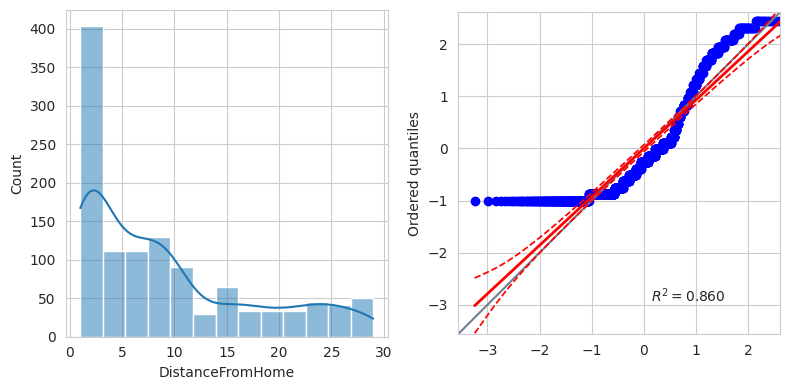

skewness: 0.97 | kurtosis: -0.23


*** MonthlyIncome ***


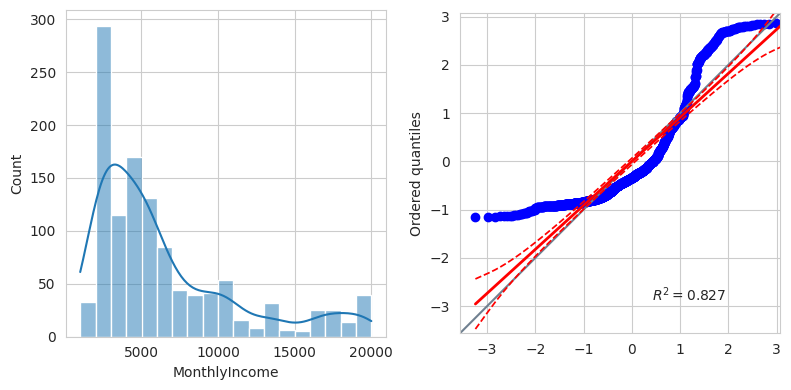

skewness: 1.37 | kurtosis: 1.0


*** NumCompaniesWorked ***


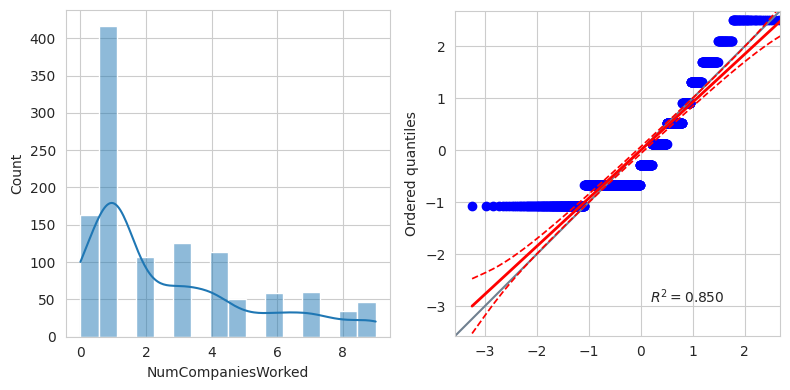

skewness: 1.01 | kurtosis: -0.02


*** PercentSalaryHike ***


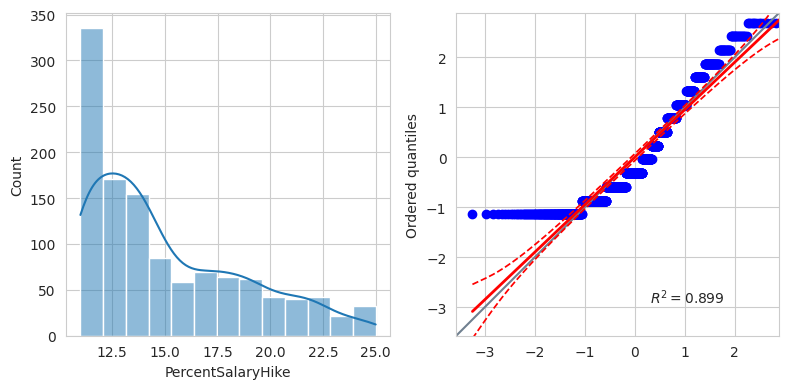

skewness: 0.85 | kurtosis: -0.25


*** TotalWorkingYears ***


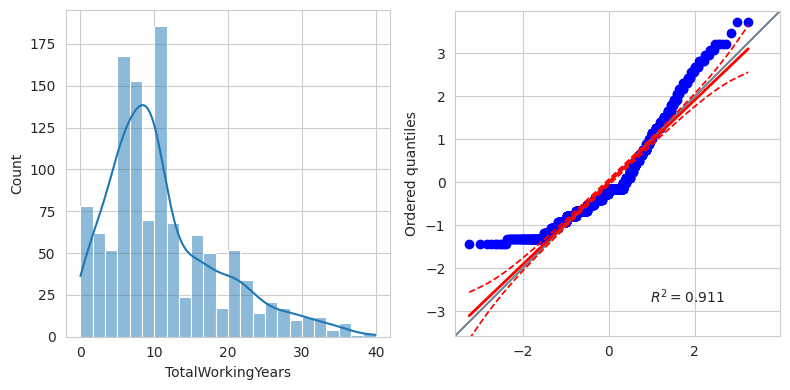

skewness: 1.1 | kurtosis: 0.87


*** YearsAtCompany ***


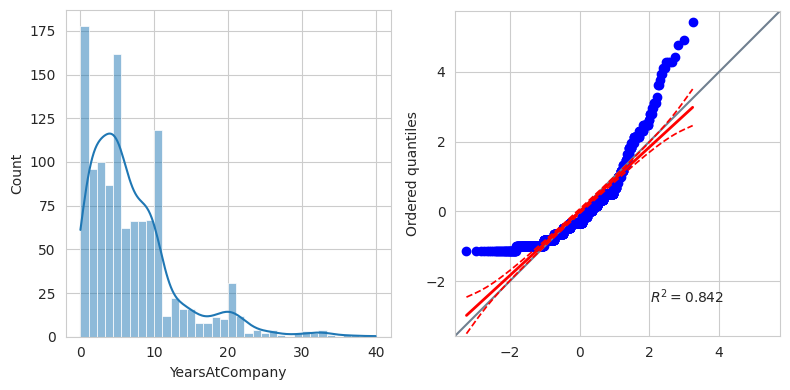

skewness: 1.76 | kurtosis: 3.98


*** YearsInCurrentRole ***


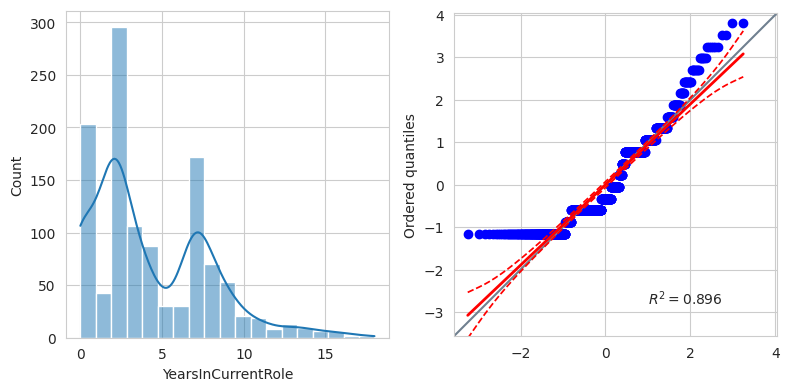

skewness: 0.93 | kurtosis: 0.47


*** YearsSinceLastPromotion ***


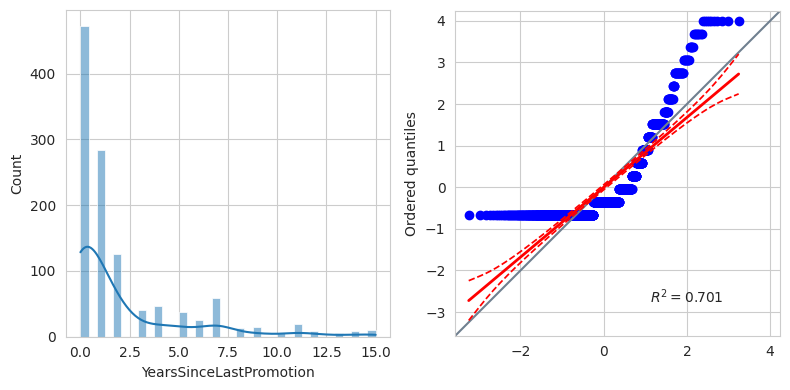

skewness: 1.99 | kurtosis: 3.64


*** YearsWithCurrManager ***


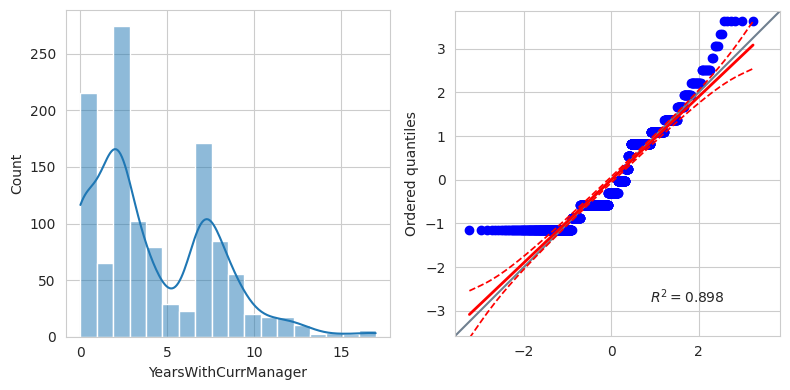

skewness: 0.82 | kurtosis: 0.15




In [5]:
apply_transform_to = []
for col in TrainSet.drop(labels='Age', axis=1).columns:
    if len(TrainSet[col].unique()) > 7 and TrainSet[col].dtype=='int64':
        apply_transform_to.append(col)

df_continuous = TrainSet.filter(apply_transform_to)
plot_distribution(df_continuous)

We can also check for outliers. We observe a large number of outliers in `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany` and `YearsSinceLastPromotion`. Ideally, we can apply a transformer like Winsorizer but for now, we will leave it as it is (as will be shown later that other 'numerical' transformers will take care of that).

In [ ]:
def plot_histogram_and_boxplot(df):
  for col in df.columns:
    fig, axes = plt.subplots(nrows=2 ,ncols=1 ,figsize=(6,6), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df, x=col, ax=axes[0])
    sns.histplot(data=df, x=col, kde=True, ax=axes[1])
    fig.suptitle(f"{col} Distribution - Boxplot and Histogram")
    plt.show()

    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    print(
        f"This is the range where a datapoint is not an outlier: from "
        f"{(df[col].quantile(q=0.25) - 1.5*IQR).round(2)} to "
        f"{(df[col].quantile(q=0.75) + 1.5*IQR).round(2)}")
    print("\n")

plot_histogram_and_boxplot(df_continuous)

---

# Numerical data transformation

We use the following function to compare the data distribution before and after the transformation.

In [10]:
def calculate_skew_kurtosis(df,col, moment):
    """
    This function is adapted from the feature engineering lesson
    """
    print(f"{moment}  | skewness: {df[col].skew().round(2)} | kurtosis: {df[col].kurtosis().round(2)}")

def compare_distributions_before_and_after_applying_transformer(df, df_transformed1, df_transformed2, method1, method2, items=None):
    if items != None:
        df = df.filter(items)
    else:
        pass

    for col in df.columns:
        print(f"*** {col} ***")
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

        plot1 = sns.histplot(data=df, x=col, kde=True, ax=axes[0,0])
        plot2 = sns.histplot(data=df_transformed1, x=col, kde=True, ax=axes[1,0], color=['green'])
        plot3 = sns.histplot(data=df_transformed2, x=col, kde=True, ax=axes[2,0], color=['red'])
        plot1.set(xlabel=None)
        plot2.set(xlabel=None)
        plot1.set_title('Before Transform')
        plot2.set_title(method1)
        plot3.set_title(method2)
        
        qqplot1 = pg.qqplot(df[col], dist='norm',ax=axes[0,1])
        qqplot2 = pg.qqplot(df_transformed1[col], dist='norm',ax=axes[1,1])
        qqplot1.set(xlabel=None)
        qqplot2.set(xlabel=None)        
        pg.qqplot(df_transformed2[col], dist='norm',ax=axes[2,1])
        
        plt.tight_layout()
        plt.show()

        calculate_skew_kurtosis(df, col, moment='before transformation')
        calculate_skew_kurtosis(df_transformed1, col, moment=f'after {method1}')
        calculate_skew_kurtosis(df_transformed2, col, moment=f'after {method2}')
        print("\n")


We can not apply logarithmic, reciprocal and BoxCox transformers since we have zeros in our data. Two exceptions from this are the columns `PercentSalaryHike` and `DistanceFromHome`, which will be treated separately after the following analysis, if it was not successful in getting a normal distribution. Therefore, we proceed with the power transformer and the Yeo Johnson transformer to all numerical variables. 

We set the pipeline with the transformer and then fit and transform the dataframe.

*** DistanceFromHome ***


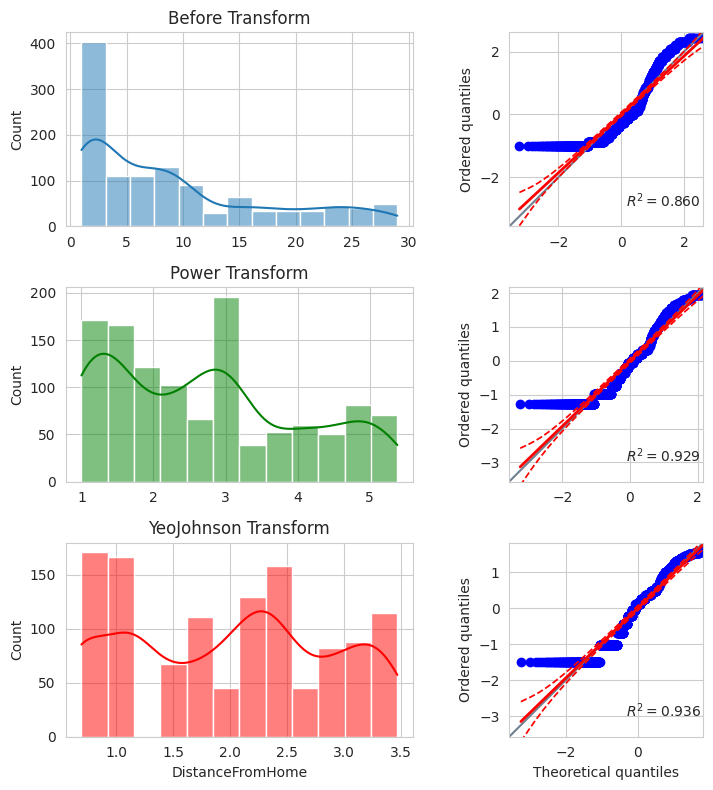

before transformation  | skewness: 0.97 | kurtosis: -0.23
after Power Transform  | skewness: 0.41 | kurtosis: -0.98
after YeoJohnson Transform  | skewness: -0.0 | kurtosis: -1.22


*** MonthlyIncome ***


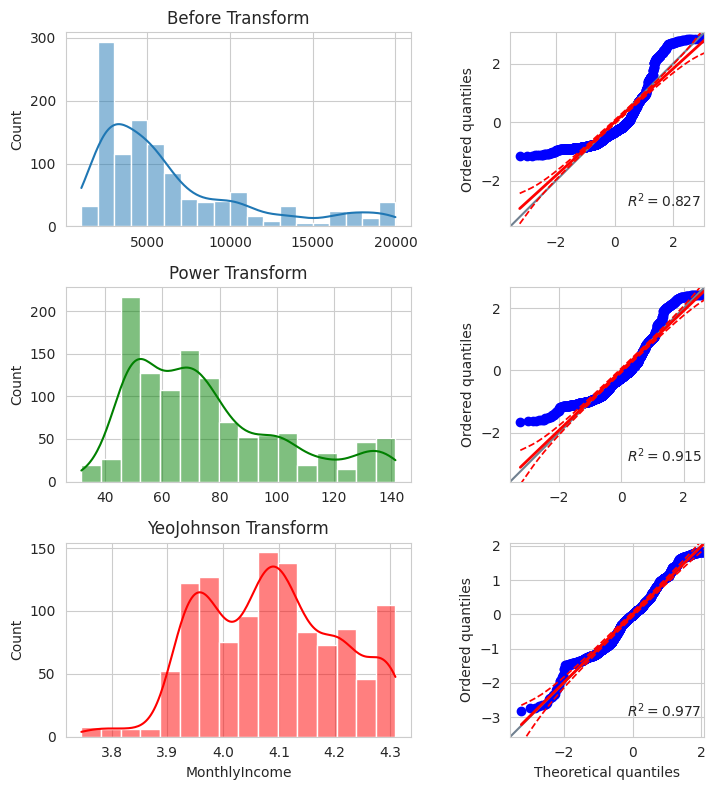

before transformation  | skewness: 1.37 | kurtosis: 1.0
after Power Transform  | skewness: 0.86 | kurtosis: -0.12
after YeoJohnson Transform  | skewness: 0.03 | kurtosis: -0.67


*** NumCompaniesWorked ***


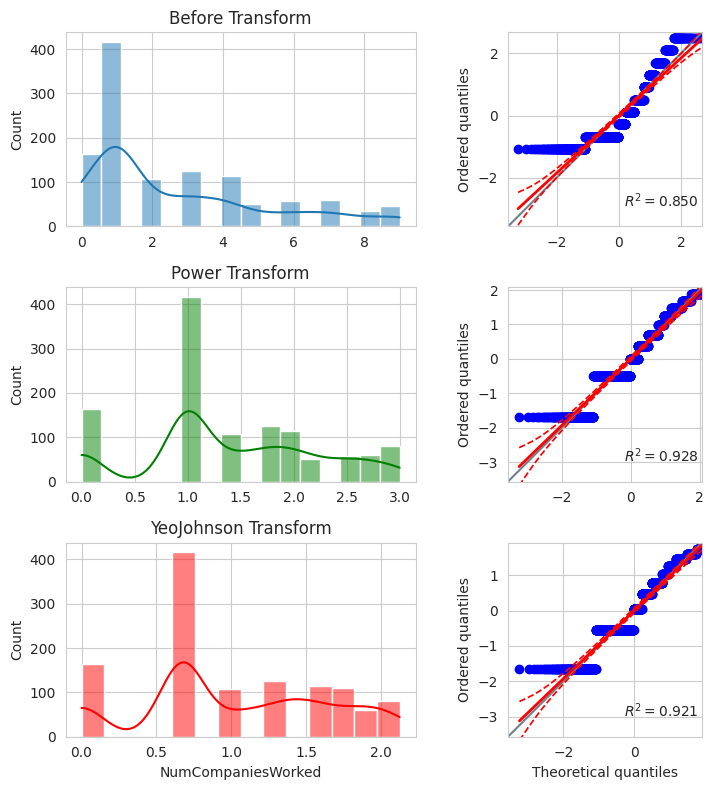

before transformation  | skewness: 1.01 | kurtosis: -0.02
after Power Transform  | skewness: 0.03 | kurtosis: -0.67
after YeoJohnson Transform  | skewness: 0.02 | kurtosis: -0.94


*** PercentSalaryHike ***


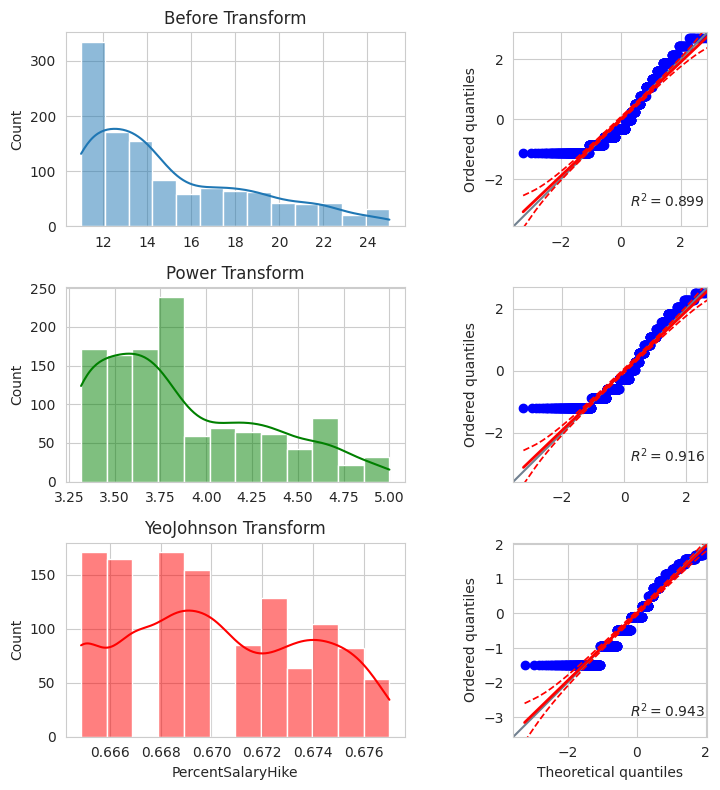

before transformation  | skewness: 0.85 | kurtosis: -0.25
after Power Transform  | skewness: 0.68 | kurtosis: -0.56
after YeoJohnson Transform  | skewness: 0.12 | kurtosis: -1.12


*** TotalWorkingYears ***


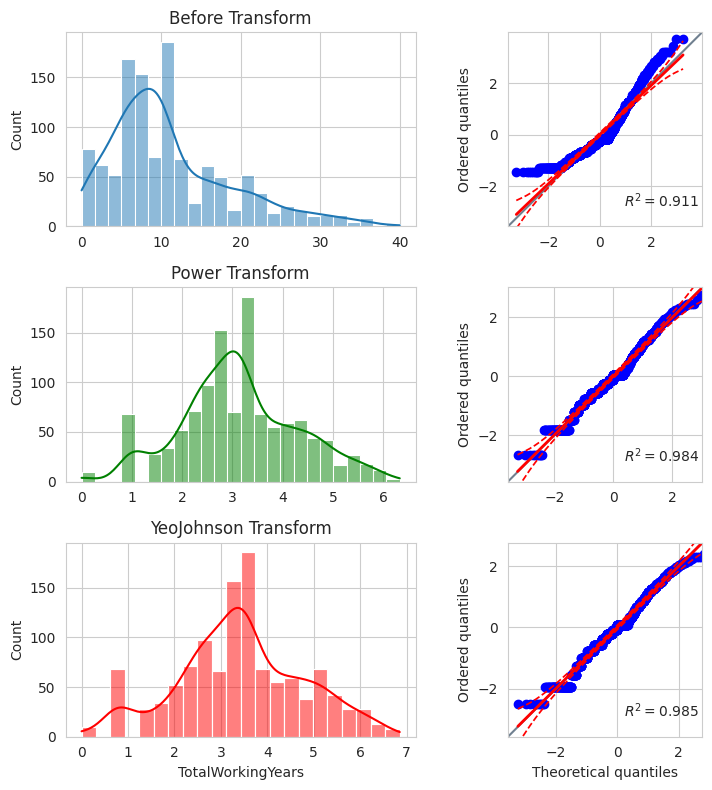

before transformation  | skewness: 1.1 | kurtosis: 0.87
after Power Transform  | skewness: 0.15 | kurtosis: -0.04
after YeoJohnson Transform  | skewness: -0.01 | kurtosis: -0.19


*** YearsAtCompany ***


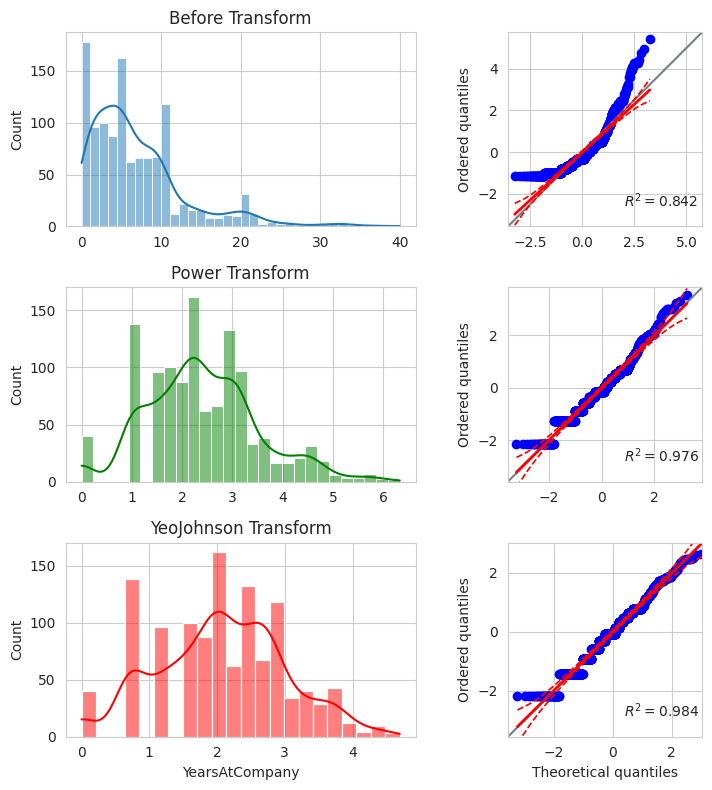

before transformation  | skewness: 1.76 | kurtosis: 3.98
after Power Transform  | skewness: 0.38 | kurtosis: 0.37
after YeoJohnson Transform  | skewness: -0.01 | kurtosis: -0.3


*** YearsInCurrentRole ***


KeyboardInterrupt: 

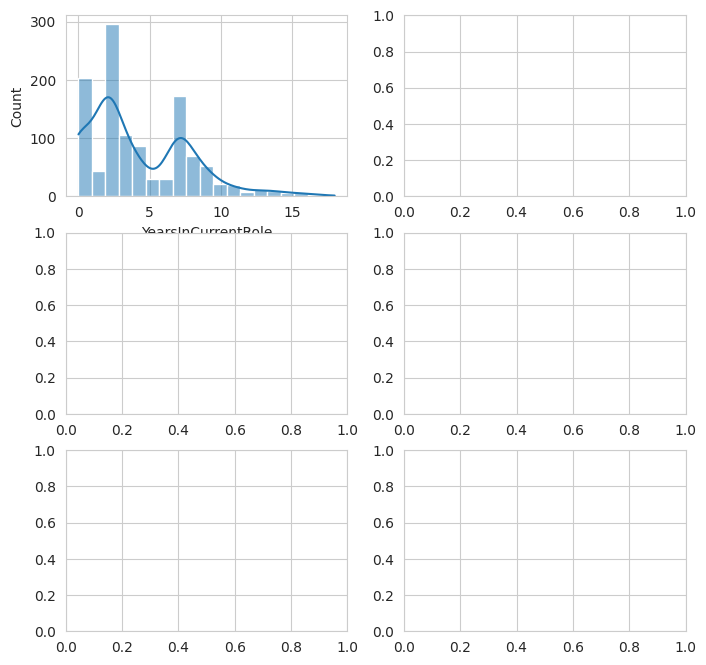

In [18]:
from feature_engine import transformation as vt
from sklearn.pipeline import Pipeline

pipeline_power = Pipeline([
      ( 'pt', vt.PowerTransformer() )
  ])
pipeline_YeoJohnson = Pipeline([
      ('yj', vt.YeoJohnsonTransformer() )
  ])

df_transformed_power = pipeline_power.fit_transform(df_continuous)
df_transformed_YeoJohnson = pipeline_YeoJohnson.fit_transform(df_continuous)

compare_distributions_before_and_after_applying_transformer(df_continuous, df_transformed_power, df_transformed_YeoJohnson, 'Power Transform', 'YeoJohnson Transform')

Comments on the numerical transformation:
* In all the plots, YeoJohnson transformation performance with superior to the Power transformation when it comes to skewness. That means the data becomes more symmetric at the center point.
* As for kurtosis, except for `YearsAtCompany`, YeoJohnson transformation generated data with higher negative kurtosis. Meaning that the distribution has thinner tails than the original data as well as the Power transformed data

Generally, the transformed data distribution resembles a normal distribution more than the original data **only for 3 variables**. These are `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`.

Therefore, we proceed with YeoJohnson transformation only on these variables in the pipeline.

Before we conclude, we run a numerical transformation on `PercentSalaryHike` and `DistanceFromHome` with other transformers. As they have non-zero values, we can perform reciprocal and logarithmic transformations to see if the distribution will get close to a normal distribution.

*** PercentSalaryHike ***


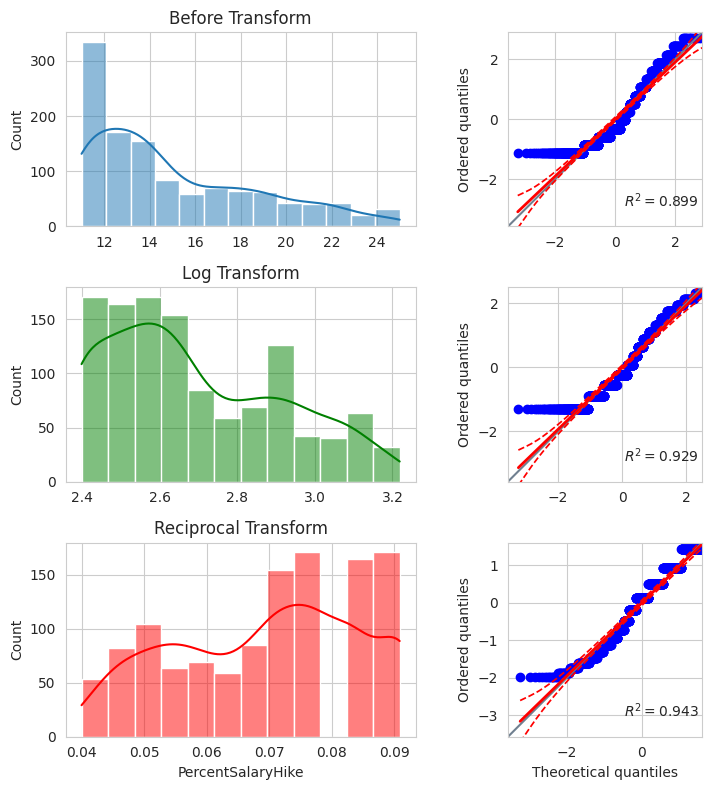

before transformation  | skewness: 0.85 | kurtosis: -0.25
after Log Transform  | skewness: 0.52 | kurtosis: -0.8
after Reciprocal Transform  | skewness: -0.21 | kurtosis: -1.08


*** DistanceFromHome ***


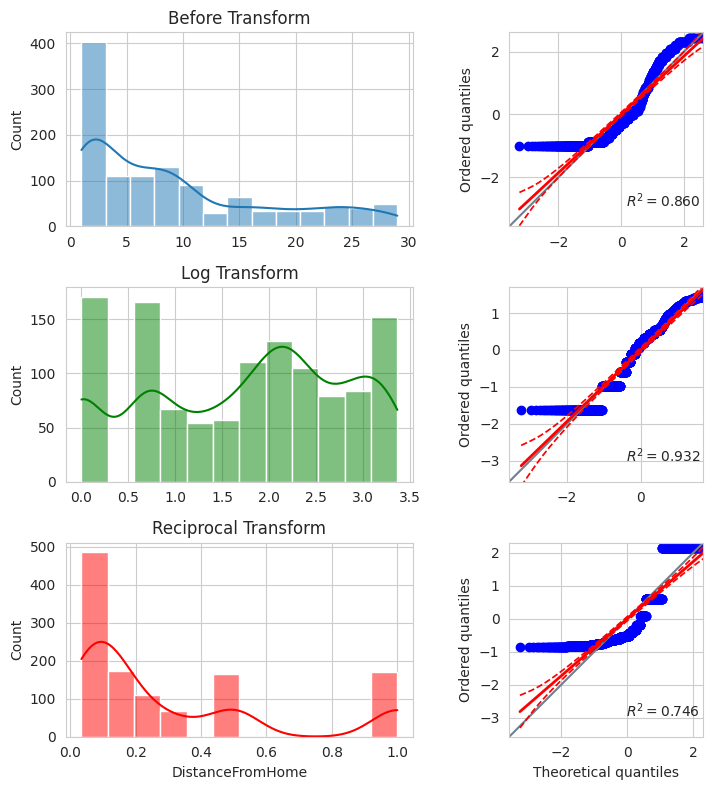

before transformation  | skewness: 0.97 | kurtosis: -0.23
after Log Transform  | skewness: -0.23 | kurtosis: -1.14
after Reciprocal Transform  | skewness: 1.3 | kurtosis: 0.31




In [12]:
pipeline_log = Pipeline([
      ( 'log', vt.LogTransformer(variables=['PercentSalaryHike','DistanceFromHome']) )
  ])
pipeline_reciprocal = Pipeline([
      ( 'reciprocal', vt.ReciprocalTransformer(variables=['PercentSalaryHike','DistanceFromHome']) )
  ])

df_transformed_log = pipeline_log.fit_transform(df_continuous)
df_transformed_reciprocal = pipeline_reciprocal.fit_transform(df_continuous)

compare_distributions_before_and_after_applying_transformer(df_continuous,
                                                            df_transformed_log,
                                                            df_transformed_reciprocal,
                                                            'Log Transform', 'Reciprocal Transform',
                                                            items=['PercentSalaryHike','DistanceFromHome'])

We see that the distribution does not improve. Finally, we perform the chosen numerical transformation on the chosen variables in the TrainSet.

In [13]:
pipeline_YeoJohnson = Pipeline([
      ('yj', vt.YeoJohnsonTransformer(variables=['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']) )
  ])

TrainSet_transformed_YeoJohnson = pipeline_YeoJohnson.fit_transform(TrainSet)

Before we conclude this section, let's look again at the outliers. We see that there has been an improvement after normalizing the distribution with Yeo Johnson transformer.

In [ ]:
plot_histogram_and_boxplot(TrainSet_transformed_YeoJohnson.filter(['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']))

---

# Ordinal Categorical Encoding

We perform categorical encoding to transform categorical variables into integers.

In [44]:
from feature_engine.encoding import OrdinalEncoder

apply_transform_to = []

for col in TrainSet.columns:
      if TrainSet[col].dtype=='object':
            apply_transform_to.append(col)

print(f'Variables to apply the transformation to are: {apply_transform_to}')
print('\n')
print(f'-------------------Before Transformation--------------------------')
print('\n')
# Before transformation
for col in TrainSet.filter(apply_transform_to).columns.to_list():
      print(f"{col} \n{TrainSet[col].unique()} \n\n")

# Transforma and fit
pipeline = Pipeline([
      ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary') )
])

TrainSet_transformed_ordinal = pipeline.fit_transform(TrainSet.filter(apply_transform_to))

print(f'-------------------After Transformation--------------------------')
print('\n')
# Check that transformation happened
for col in TrainSet_transformed_ordinal.filter(apply_transform_to).columns.to_list():
      print(f"{col} \n{TrainSet_transformed_ordinal[col].unique()} \n\n")

Variables to apply the transformation to are: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


-------------------Before Transformation--------------------------


BusinessTravel 
['Travel_Rarely' 'Non-Travel' 'Travel_Frequently'] 


Department 
['Sales' 'Research & Development' 'Human Resources'] 


EducationField 
['Life Sciences' 'Technical Degree' 'Marketing' 'Medical'
 'Human Resources' 'Other'] 


Gender 
['Female' 'Male'] 


JobRole 
['Manager' 'Research Scientist' 'Sales Executive' 'Sales Representative'
 'Laboratory Technician' 'Manufacturing Director' 'Human Resources'
 'Research Director' 'Healthcare Representative'] 


MaritalStatus 
['Married' 'Single' 'Divorced'] 


OverTime 
['Yes' 'No'] 


-------------------After Transformation--------------------------


BusinessTravel 
[0 1 2] 


Department 
[0 1 2] 


EducationField 
[0 1 2 3 4 5] 


Gender 
[0 1] 


JobRole 
[0 1 2 3 4 5 6 7 8] 


MaritalStatus 
[0 1 2] 


OverT

---

# Smart correlated selection

We look for groups of features that correlate strongly amongst themselves. A threshold of 0.6 means that any variable correlations that are at least moderate will be considered and subject to removal

In [63]:
from feature_engine.selection import SmartCorrelatedSelection
pipeline = Pipeline([
      ( 'SmartCorrelatedSelection', SmartCorrelatedSelection(method="spearman",
                                                             threshold=0.6,
                                                             selection_method="variance",))
])

TrainSet_transformed_smart_correlation = pipeline.fit_transform(TrainSet)

# sets of features were marked as correlated
pipeline['SmartCorrelatedSelection'].correlated_feature_sets_

[{'Age', 'TotalWorkingYears'},
 {'JobLevel', 'MonthlyIncome'},
 {'PercentSalaryHike', 'PerformanceRating'},
 {'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager'}]

In [64]:
pipeline['SmartCorrelatedSelection'].features_to_drop_

['JobLevel',
 'PerformanceRating',
 'TotalWorkingYears',
 'YearsInCurrentRole',
 'YearsWithCurrManager']

In [65]:
# check that the transformation occured
TrainSet_transformed_smart_correlation.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion
0,58,0,Travel_Rarely,Sales,21,3,Life Sciences,4,Female,3,...,17875,4,Yes,13,3,1,2,2,1,0
1,45,0,Travel_Rarely,Research & Development,28,3,Technical Degree,4,Male,3,...,2132,4,No,20,4,1,3,3,5,0
2,40,0,Travel_Rarely,Sales,26,3,Marketing,3,Male,3,...,8396,1,No,14,2,1,3,2,7,7
3,36,0,Non-Travel,Sales,8,4,Life Sciences,1,Male,2,...,7587,1,No,15,2,0,1,3,10,0
4,25,1,Travel_Frequently,Sales,24,1,Life Sciences,3,Male,1,...,1118,1,Yes,14,4,0,4,3,1,1


---

# Conclusions

The transformations that will be added to the ML pipeline are:
* Ordinal categorical encoding on ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
* Yeo Johnson numerical transformation on ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
* Smart correlation selection: ['JobLevel', 'PerformanceRating', 'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager']